In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats


In [17]:
DATA_PATH = os.path.join("..", "candles", "train_sample.csv")
ROLLING_WINDOW = 7 * 24 * 12
df = pd.read_csv(DATA_PATH)
df["open_time"] = pd.to_datetime(df["open_time"])

print("Size:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Size: (17280, 12)
Columns: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote', 'volume_log', 'volume_log_z']
            open_time     open     high      low    close     volume  \
0 2024-01-01 00:00:00  2281.87  2287.84  2281.27  2287.84   910.5701   
1 2024-01-01 00:05:00  2287.83  2291.83  2287.06  2290.77  1652.9290   
2 2024-01-01 00:10:00  2290.77  2296.97  2290.76  2296.71  1829.5259   
3 2024-01-01 00:15:00  2296.71  2297.00  2292.36  2292.36   890.8524   
4 2024-01-01 00:20:00  2292.37  2295.87  2292.30  2294.67   763.7046   

   quote_asset_volume  num_trades  taker_buy_base  taker_buy_quote  \
0        2.080313e+06        2593        585.7254     1.338369e+06   
1        3.785227e+06        3354       1058.4951     2.423910e+06   
2        4.197682e+06        3321       1033.8721     2.372038e+06   
3        2.044781e+06        2332        249.9496     5.737015e+05   
4        1.751663e+06        20

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open_time           17280 non-null  datetime64[ns]
 1   open                17280 non-null  float64       
 2   high                17280 non-null  float64       
 3   low                 17280 non-null  float64       
 4   close               17280 non-null  float64       
 5   volume              17280 non-null  float64       
 6   quote_asset_volume  17280 non-null  float64       
 7   num_trades          17280 non-null  int64         
 8   taker_buy_base      17280 non-null  float64       
 9   taker_buy_quote     17280 non-null  float64       
 10  volume_log          17280 non-null  float64       
 11  volume_log_z        17280 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 1.6 MB


In [4]:
# === Data diagnostics ===
print("\n== Missing values (NaN) ==")
print(df.isna().sum())

print("\n== Infinite values (inf) ==")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

print("\n== Data types and general info ==")
print(df.info())

print("\n== Descriptive statistics ==")
print(df.describe().T)


== Missing values (NaN) ==
open_time             0
open                  0
high                  0
low                   0
close                 0
volume                0
quote_asset_volume    0
num_trades            0
taker_buy_base        0
taker_buy_quote       0
volume_log            0
volume_log_z          0
dtype: int64

== Infinite values (inf) ==
open                  0
high                  0
low                   0
close                 0
volume                0
quote_asset_volume    0
num_trades            0
taker_buy_base        0
taker_buy_quote       0
volume_log            0
volume_log_z          0
dtype: int64

== Data types and general info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open_time           17280 non-null  object 
 1   open                17280 non-null  float64
 2   high                

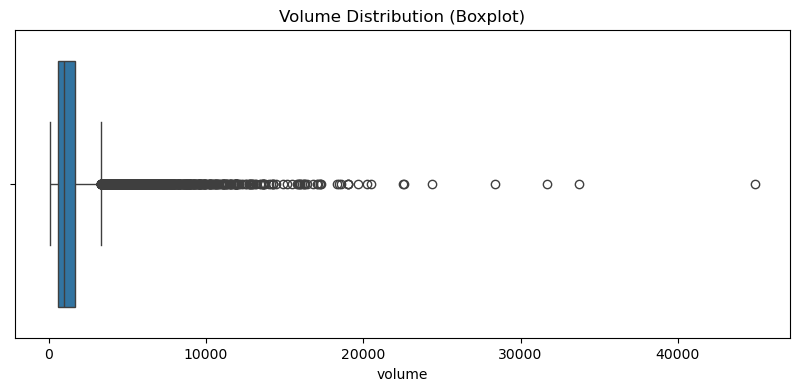

In [5]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["volume"])
plt.title("Volume Distribution (Boxplot)")
plt.show()


In [14]:
z_scores = np.abs(stats.zscore(df["volume"]))
outliers = df[z_scores > 5]
print(f"Number of volume outliers (>5 std): {len(outliers)}")
print(outliers[["open_time", "volume"]].head())


Number of volume outliers (>5 std): 116
               open_time      volume
719  2024-01-03 11:55:00  12509.6855
720  2024-01-03 12:00:00  28353.6717
721  2024-01-03 12:05:00  31675.4891
722  2024-01-03 12:10:00  33739.8904
723  2024-01-03 12:15:00  19688.3521


## **116 cases above 5σ in just three months**

In traditional finance, a **5-sigma event** (five standard deviations away from the mean) is something you might see **once in a decade** — maybe when a bank implodes or the market collectively loses its mind.

But Ethereum?  
Ethereum doesn’t *do* normality. It runs on **adrenaline and chaos**.

These **116 outlier spikes in volume** are likely caused by:

- **Liquidity shocks** — sudden inflows or drains of capital.  
- **Arbitrage bots** exploiting micro-price differences.  
- **Flash loans** and **DeFi liquidations** detonating short-term volume.  
- **Front-running** and high-frequency trading bursts.

From a modeling perspective:

- For **GARCH / EGARCH**, these extreme values are *gold*: they represent **volatility clustering**, the very phenomenon the models aim to capture.  
- For **exploratory visualization** (histograms, correlations, scatterplots), these spikes distort the scale. In that case, temporarily filtering out the top **1% quantile** makes the plots more readable, without losing statistical integrity.

In short:  
Leave the madness in for the model — trim it out only for the charts.


In [24]:
# Classical rolling mean and std
df["rolling_mean"] = df["volume"].rolling(ROLLING_WINDOW, min_periods=100).mean()
df["rolling_std"] = df["volume"].rolling(ROLLING_WINDOW, min_periods=100).std()

# Robust rolling median and MAD (Median Absolute Deviation)
df["rolling_median"] = df["volume"].rolling(ROLLING_WINDOW, min_periods=100).median()
df["rolling_mad"] = (
    df["volume"]
    .rolling(ROLLING_WINDOW, min_periods=100)
    .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=False)
)
EWM_SPAN = ROLLING_WINDOW // 10  # ~200, reacts faster than 7-day full window

df["ewm_volume"] = df["volume"].ewm(span=EWM_SPAN, adjust=False).mean()
df["ewm_mad"] = (
    np.abs(df["volume"] - df["ewm_volume"])
    .ewm(span=EWM_SPAN, adjust=False)
    .mean()
)

<span style="font-size:22px; font-weight:bold;"> The  early-warning indicator?</span>

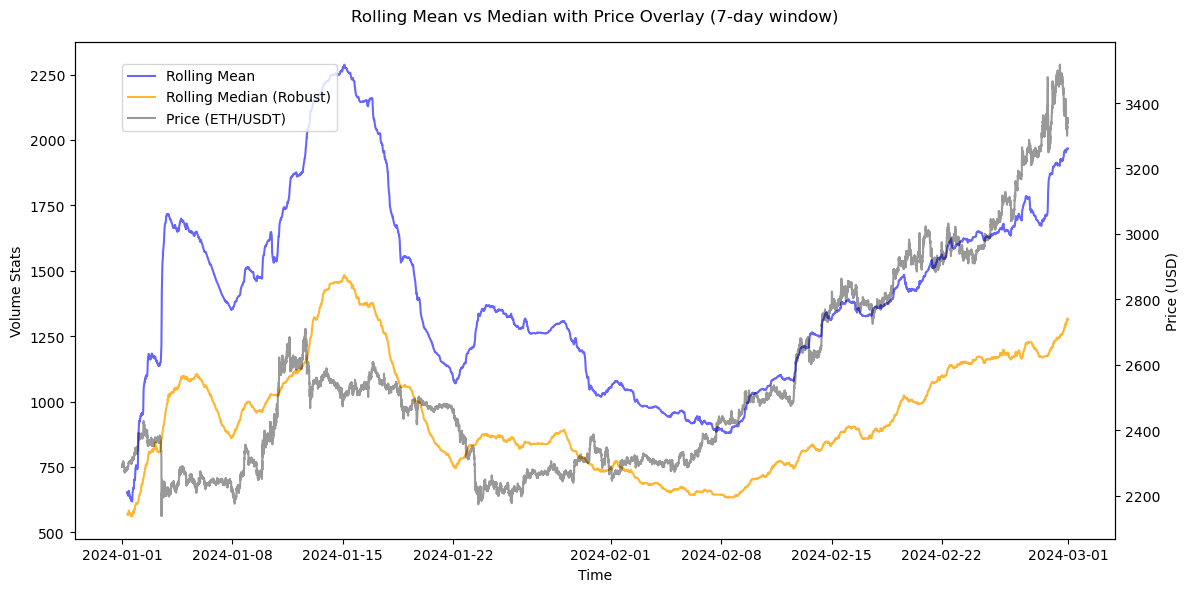

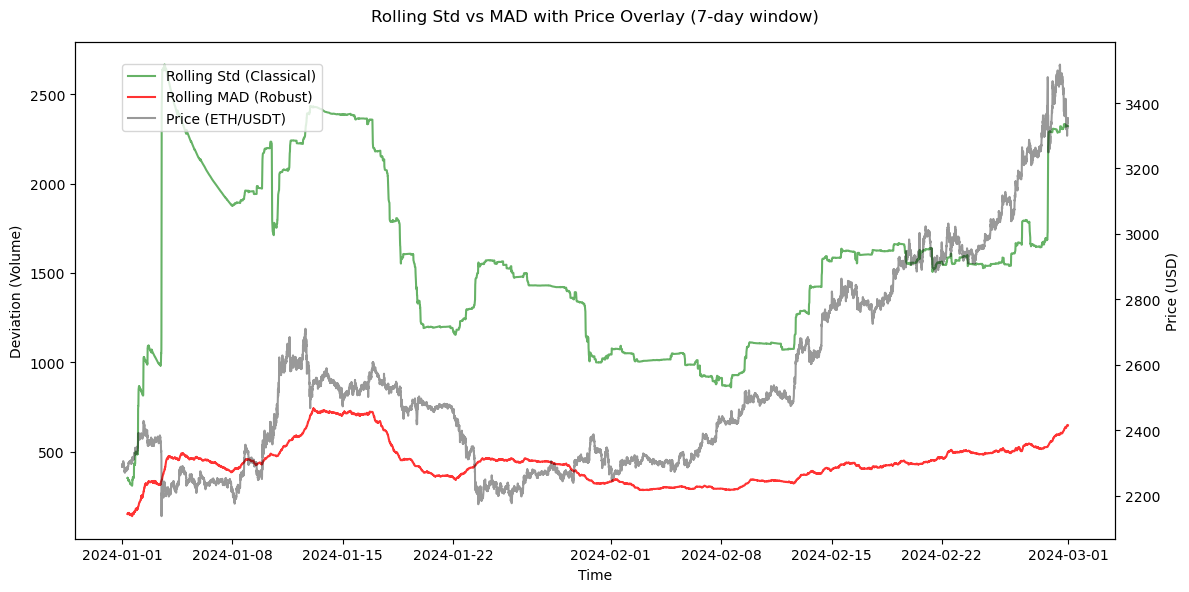

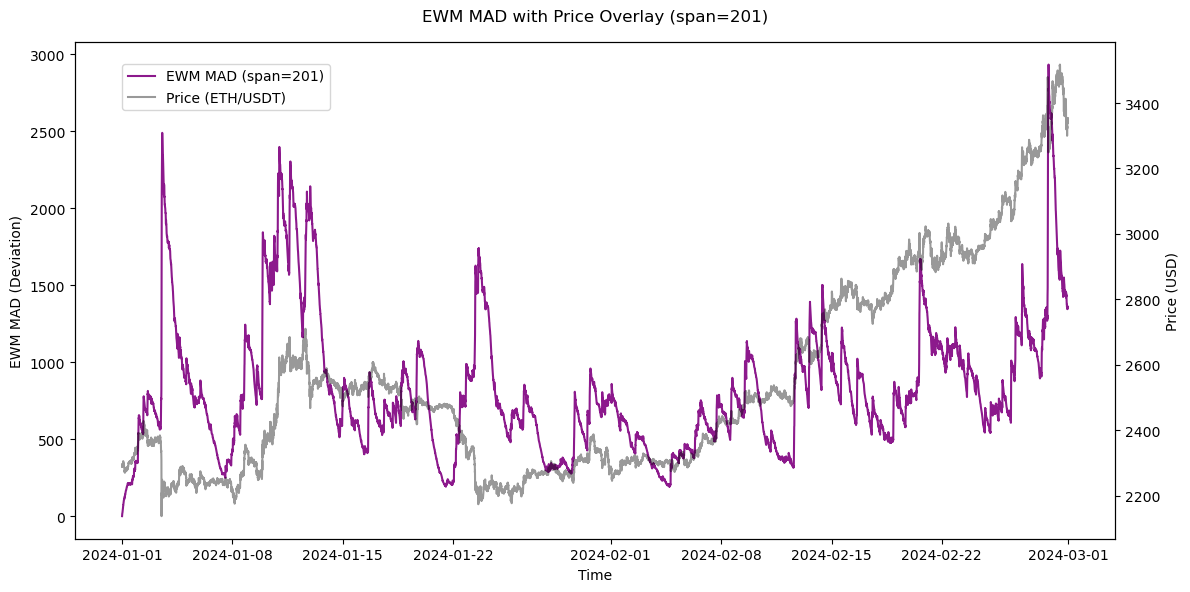

In [27]:
# --- 1. Rolling Mean vs Median + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["rolling_mean"], label="Rolling Mean", color="blue", alpha=0.6)
ax1.plot(df["open_time"], df["rolling_median"], label="Rolling Median (Robust)", color="orange", alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume Stats")
ax1.tick_params(axis="y", labelcolor="black")

# Second axis for price
ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Rolling Mean vs Median with Price Overlay (7-day window)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


# --- 2. Rolling Std vs MAD + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["rolling_std"], label="Rolling Std (Classical)", color="green", alpha=0.6)
ax1.plot(df["open_time"], df["rolling_mad"], label="Rolling MAD (Robust)", color="red", alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Deviation (Volume)")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Rolling Std vs MAD with Price Overlay (7-day window)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


# --- 3. EWM MAD + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["ewm_mad"], label=f"EWM MAD (span={EWM_SPAN})", color="purple", alpha=0.9)
ax1.set_xlabel("Time")
ax1.set_ylabel("EWM MAD (Deviation)")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle(f"EWM MAD with Price Overlay (span={EWM_SPAN})")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()